### Unified summary: Baseline (closed APIs) vs Open models
- Success rate, mean duration, total tokens, estimated API cost
- Uses status.json and telemetry.json from `dataset/baseline` and `dataset/openmodels`
- Short, article-ready table + one-line takeaway


Created symlink: /Users/evgenii.kniazev/projects/app.build-neurips25/analysis/dataset -> /Users/evgenii.kniazev/projects/app.build-neurips25/dataset


In [13]:
from __future__ import annotations
import hashlib, json
from pathlib import Path
import pandas as pd
import numpy as np

# Minimal: gather (status+telemetry) and print compact summary. Excludes NiceGUI.

def _extract_ablation_type(results_path: Path) -> str:
    for part in results_path.parts:
        if part.startswith("benchmark_results_") and part != "benchmark_results":
            return part.replace("benchmark_results_", "")
    return "baseline"


def _check_template_failed(experiment_dir: Path, template_id: str) -> bool:
    if template_id != "trpc-agent":
        return False
    p = experiment_dir / "source_code" / "client" / "src" / "App.tsx"
    if not p.exists():
        return False
    try:
        return hashlib.md5(p.read_bytes()).hexdigest() == "eeb92b801087f89346a7ad3c1baa5163"
    except Exception:
        return False


def _load_dir(results_dir: Path) -> pd.DataFrame:
    rows: list[dict] = []
    if not (results_dir and results_dir.exists()):
        return pd.DataFrame(rows)
    for d in results_dir.iterdir():
        if not d.is_dir() or d.name == ".DS_Store":
            continue
        sp, tp = d / "status.json", d / "telemetry.json"
        if not sp.exists():
            continue
        try:
            st = json.loads(sp.read_text())
        except Exception:
            continue
        tel = {}
        if tp.exists():
            try:
                tel = json.loads(tp.read_text())
            except Exception:
                tel = {}
        parts = d.name.split("_")
        prompt, template, coding, uni = (parts + ["unknown"] * 4)[:4]
        hc = bool(st.get("success", False))
        tf = _check_template_failed(d, template)
        row = {
            "experiment_name": d.name,
            "prompt_name": prompt,
            "template_id": template,
            "coding_model": coding,
            "universal_model": uni,
            "ablation_type": _extract_ablation_type(results_dir),
            "success": bool(hc and not tf),
            "duration_seconds": st.get("duration_seconds", 0.0),
            "total_input_tokens": 0,
            "total_output_tokens": 0,
        }
        for _, m in (tel or {}).items():
            row["total_input_tokens"] += m.get("total_input_tokens", 0)
            row["total_output_tokens"] += m.get("total_output_tokens", 0)
        rows.append(row)
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df[df["template_id"] != "nicegui-agent"].reset_index(drop=True)
    return df

# Resolve dirs
CANDS = lambda sub: [Path(sub), Path.cwd() / sub, Path("/Users/evgenii.kniazev/projects/app.build-neurips25") / sub]
base_dir = next((p for p in CANDS("dataset/baseline") if p.exists()), None)
open_dir = next((p for p in CANDS("dataset/openmodels") if p.exists()), None)

base_df = _load_dir(base_dir)
open_df = _load_dir(open_dir)

# Pricing (USD per 1M tokens)
PRICES = {"anthropic": (3.0, 15.0), "gemini": (0.15, 0.60), "openai": (5.0, 15.0)}

def _family_from_row(r):
    mk = (r.get("coding_model", "") + " " + r.get("universal_model", "")).lower()
    if "claude" in mk: return "anthropic"
    if "gemini" in mk: return "gemini"
    if "gpt" in mk: return "openai"
    return "open"

def est_cost(df: pd.DataFrame) -> float:
    if df.empty: return 0.0
    tmp = df.copy()
    tmp["family"] = tmp.apply(_family_from_row, axis=1)
    cost = 0.0
    for fam, grp in tmp.groupby("family"):
        rate_in, rate_out = PRICES.get(fam, (0.0, 0.0))
        cost += (grp["total_input_tokens"].sum() / 1e6) * rate_in
        cost += (grp["total_output_tokens"].sum() / 1e6) * rate_out
    return float(cost)

summ = []
for label, df in [("Baseline (closed APIs)", base_df), ("Open models", open_df)]:
    summ.append({
        "cohort": label,
        "num_runs": len(df),
        "success_rate": (df["success"].mean() if not df.empty else np.nan),
        "mean_duration_s": (df["duration_seconds"].mean() if not df.empty else np.nan),
        "total_input_tokens": int(df["total_input_tokens"].sum() if not df.empty else 0),
        "total_output_tokens": int(df["total_output_tokens"].sum() if not df.empty else 0),
        "est_cost_usd": est_cost(df),
    })
summary_df = pd.DataFrame(summ)

fmt = summary_df.copy()
fmt["success_rate"] = fmt["success_rate"].map(lambda x: "--" if pd.isna(x) else f"{x*100:.1f}%")
fmt["mean_duration_s"] = fmt["mean_duration_s"].round(1)
fmt["est_cost_usd"] = fmt["est_cost_usd"].round(2)

try:
    display(fmt[["cohort", "num_runs", "success_rate", "mean_duration_s", "total_input_tokens", "total_output_tokens", "est_cost_usd"]])
except Exception:
    print(fmt.to_string(index=False))

try:
    b, o = summary_df.iloc[0], summary_df.iloc[1]
    print(f"Closed APIs: {fmt.loc[0,'success_rate']}, ~{b['mean_duration_s']:.0f}s, ${b['est_cost_usd']:.2f}; "
          f"Open models: {fmt.loc[1,'success_rate']}, ~{o['mean_duration_s']:.0f}s, ${o['est_cost_usd']:.2f}.")
except Exception:
    pass


,cohort,num_runs,success_rate,mean_duration_s,total_input_tokens,total_output_tokens,est_cost_usd
0,Baseline (closed APIs),30,86.7%,478.3,27691026,1808588,110.20
1,Open models,180,56.7%,628.6,219116367,7771684,37.53


Closed APIs: 86.7%, ~478s, $110.20; Open models: 56.7%, ~629s, $37.53.


In [14]:
# Override: make scan_baseline_runs robust and no-op if dataset/baseline is missing
from pathlib import Path
import pandas as pd

try:
    ROOT
except NameError:
    ROOT = Path.cwd()

BASELINE_FALLBACKS = [
    Path("dataset/baseline"),
    ROOT / "dataset/baseline",
    Path("/Users/evgenii.kniazev/projects/app.build-neurips25/dataset/baseline"),
]


def scan_baseline_runs(base_dir: Path | str):  # type: ignore[override]
    p = Path(base_dir)
    if not p.exists():
        for c in BASELINE_FALLBACKS:
            if c.exists():
                p = c
                break
    if not p.exists():
        runs_df = pd.DataFrame(columns=[
            "run_dir", "prompt_name", "template_id", "coding_model", "universal_model",
            "success", "duration_seconds"
        ])
        usage_df = pd.DataFrame(columns=[
            "run_dir", "total_calls", "total_input_tokens", "total_output_tokens", "total_time_seconds"
        ])
        merged = runs_df.merge(
            usage_df.groupby("run_dir", as_index=False).sum(), on="run_dir", how="left"
        )
        print("scan_baseline_runs: dataset/baseline not found; returning empty frames.")
        return runs_df, usage_df, merged

    # Fallback to minimal loader if needed
    rows_runs, rows_usage = [], []
    for d in sorted(x for x in p.iterdir() if x.is_dir()):
        sp, tp = d / "status.json", d / "telemetry.json"
        if not sp.exists():
            continue
        try:
            st = pd.read_json(sp)
        except Exception:
            continue
        cfg = st.get("config", {}) if isinstance(st, dict) else {}
        rows_runs.append({
            "run_dir": d.name,
            "prompt_name": (cfg.get("prompt_name") if isinstance(cfg, dict) else None),
            "template_id": (cfg.get("template_id") if isinstance(cfg, dict) else None),
            "coding_model": (cfg.get("coding_model_name") if isinstance(cfg, dict) else None),
            "universal_model": (cfg.get("universal_model_name") if isinstance(cfg, dict) else None),
            "success": bool((st.get("success") if isinstance(st, dict) else False)),
            "duration_seconds": (st.get("duration_seconds") if isinstance(st, dict) else None),
        })
        if tp.exists():
            try:
                tel = pd.read_json(tp, typ="series").to_dict()
            except Exception:
                tel = {}
            for mk, s in (tel or {}).items():
                stats = s if isinstance(s, dict) else {}
                rows_usage.append({
                    "run_dir": d.name,
                    "total_calls": stats.get("total_calls", 0),
                    "total_input_tokens": stats.get("total_input_tokens", 0),
                    "total_output_tokens": stats.get("total_output_tokens", 0),
                    "total_time_seconds": stats.get("total_time_seconds", 0.0),
                })
    runs_df = pd.DataFrame(rows_runs)
    usage_df = pd.DataFrame(rows_usage)
    per_run_usage = usage_df.groupby("run_dir", as_index=False).sum() if not usage_df.empty else usage_df
    merged = runs_df.merge(per_run_usage, on="run_dir", how="left")
    return runs_df, usage_df, merged


In [15]:
# Human-check success rate: Baseline vs Open models (from CSVs)
import pandas as pd
from pathlib import Path

# Robust CSV path resolution
CSV_CANDIDATES = [
    Path("analysis/app.build-neurips25 - baseline.csv"),
    Path("/Users/evgenii.kniazev/projects/app.build-neurips25/analysis/app.build-neurips25 - baseline.csv"),
]

OPEN_CSV_CANDIDATES = [
    Path("analysis/app.build-neurips25 - openmodels.csv"),  # optional, if present
]

def first_existing(paths):
    for p in paths:
        try:
            if p.exists():
                return p
        except Exception:
            pass
    return None

base_csv = first_existing(CSV_CANDIDATES)
if base_csv is None:
    raise FileNotFoundError("Baseline CSV not found. Expected under analysis/.")

baseline_df = pd.read_csv(base_csv)

# Normalize AB columns like earlier logic
AB_COLUMNS = [
    "AB-01 Boot", "AB-02 Prompt", "AB-03 Create", "AB-04 View/Edit",
    "AB‑06 Clickable Sweep", "AB‑07 Performance >75"
]

# Human-checked success rate: V = 1 if AB-01 and AB-02 are not FAIL
V = ((baseline_df["AB-01 Boot"].str.upper() != "FAIL") & (baseline_df["AB-02 Prompt"].str.upper() != "FAIL")).astype(int)
base_success = V.mean()

print(f"Baseline (closed APIs) human-check success (V): {base_success:.2%}  (n={len(baseline_df)})")

# If an openmodels CSV exists with the same columns, load and compare
open_csv = first_existing(OPEN_CSV_CANDIDATES)
if open_csv and open_csv.exists():
    open_df = pd.read_csv(open_csv)
    V_open = ((open_df["AB-01 Boot"].str.upper() != "FAIL") & (open_df["AB-02 Prompt"].str.upper() != "FAIL")).astype(int)
    open_success = V_open.mean()
    print(f"Open models human-check success (V): {open_success:.2%}  (n={len(open_df)})")
else:
    print("Open models CSV not found under analysis/. Provide openmodels CSV to include this comparison.")


Baseline (closed APIs) human-check success (V): 73.33%  (n=30)
Open models CSV not found under analysis/. Provide openmodels CSV to include this comparison.


In [16]:
# Data gathering via analyze_benchmark logic (exclude NiceGUI)
from pathlib import Path
import hashlib
import json
import pandas as pd

# Helpers adapted from analyze_benchmark.py

def _extract_ablation_type(results_path: Path) -> str:
    for part in results_path.parts:
        if part.startswith("benchmark_results_") and part != "benchmark_results":
            return part.replace("benchmark_results_", "")
    return "baseline"


def _check_template_failed(experiment_dir: Path, template_id: str) -> bool:
    if template_id != "trpc-agent":
        return False
    app_tsx_path = experiment_dir / "source_code" / "client" / "src" / "App.tsx"
    if not app_tsx_path.exists():
        return False
    try:
        with app_tsx_path.open("rb") as f:
            content = f.read()
            md5_hash = hashlib.md5(content).hexdigest()
            return md5_hash == "eeb92b801087f89346a7ad3c1baa5163"
    except Exception:
        return False


def _load_experiment_data(results_dir: Path) -> list[dict]:
    if not results_dir.exists():
        return []
    results: list[dict] = []
    for experiment_dir in results_dir.iterdir():
        if not experiment_dir.is_dir() or experiment_dir.name == ".DS_Store":
            continue
        status_file = experiment_dir / "status.json"
        telemetry_file = experiment_dir / "telemetry.json"
        if not status_file.exists():
            continue
        try:
            with status_file.open("rb") as f:
                status_data = json.load(f)
        except Exception:
            continue
        telemetry_data = {}
        if telemetry_file.exists():
            try:
                with telemetry_file.open("rb") as f:
                    telemetry_data = json.load(f)
            except Exception:
                telemetry_data = {}
        parts = experiment_dir.name.split("_")
        if len(parts) >= 4:
            prompt_name, template_id, coding_model, universal_model = parts[:4]
        else:
            prompt_name = experiment_dir.name
            template_id = "unknown"
            coding_model = "unknown"
            universal_model = "unknown"
        healthcheck_pass = status_data.get("success", False)
        template_failed = _check_template_failed(experiment_dir, template_id)
        row = {
            "experiment_name": experiment_dir.name,
            "prompt_name": prompt_name,
            "template_id": template_id,
            "coding_model": coding_model,
            "universal_model": universal_model,
            "ablation_type": _extract_ablation_type(results_dir),
            "healthcheck_pass": bool(healthcheck_pass),
            "success": bool(healthcheck_pass and not template_failed),
            "exit_code": status_data.get("exit_code", -1),
            "docker_healthy": status_data.get("docker_healthy", False),
            "duration_seconds": status_data.get("duration_seconds", 0.0),
            "timestamp": status_data.get("timestamp", ""),
            "template_failed": bool(template_failed),
            "total_input_tokens": 0,
            "total_output_tokens": 0,
            "total_llm_calls": 0,
            "total_llm_time": 0.0,
            "source_dir": str(results_dir),
        }
        for _, metrics in (telemetry_data or {}).items():
            row["total_input_tokens"] += metrics.get("total_input_tokens", 0)
            row["total_output_tokens"] += metrics.get("total_output_tokens", 0)
            row["total_llm_calls"] += metrics.get("total_calls", 0)
            row["total_llm_time"] += metrics.get("total_time_seconds", 0.0)
        results.append(row)
    return results


def _resolve_dir(candidates: list[Path]) -> Path | None:
    for p in candidates:
        try:
            if p.exists():
                return p
        except Exception:
            pass
    return None

ROOT = Path.cwd()
BASE_CANDS = [
    Path("dataset/baseline"),
    ROOT / "dataset/baseline",
    Path("/Users/evgenii.kniazev/projects/app.build-neurips25/dataset/baseline"),
]
OPEN_CANDS = [
    Path("dataset/openmodels"),
    ROOT / "dataset/openmodels",
    Path("/Users/evgenii.kniazev/projects/app.build-neurips25/dataset/openmodels"),
]

base_dir = _resolve_dir(BASE_CANDS)
open_dir = _resolve_dir(OPEN_CANDS)

base_rows = _load_experiment_data(base_dir) if base_dir else []
open_rows = _load_experiment_data(open_dir) if open_dir else []

runs_base_nb = pd.DataFrame(base_rows)
runs_open_nb = pd.DataFrame(open_rows)

# Exclude NiceGUI
if not runs_base_nb.empty:
    runs_base_nb = runs_base_nb[runs_base_nb["template_id"] != "nicegui-agent"].reset_index(drop=True)
if not runs_open_nb.empty:
    runs_open_nb = runs_open_nb[runs_open_nb["template_id"] != "nicegui-agent"].reset_index(drop=True)

print(f"Loaded baseline experiments: {len(runs_base_nb)}  | open models: {len(runs_open_nb)}")


Loaded baseline experiments: 30  | open models: 180


# Baseline vs Ablations: Validation Impact Analysis

This notebook analyzes how disabling validation checks affects app generation quality.

**Key Question:** Do validation layers improve final app quality, or do they overly constrain the system?

## Experimental Setup
- **Baseline:** Full app.build system with all checks enabled
- **Ablations:** Same 30 test cases with individual checks disabled:
  - `no_lint`: Linting disabled
  - `no_tests`: Unit tests disabled  
  - `no_playwright`: E2E browser tests disabled

## Metrics
- **Viability (V):** Binary - app boots and responds to prompts (AB-01, AB-02 ≠ FAIL)
- **Quality (Q):** 0-10 score averaging across all AB checks

In [17]:
from __future__ import annotations
import json
from pathlib import Path
import pandas as pd
import numpy as np

# Baseline status.json + telemetry.json aggregation

def scan_baseline_runs(base_dir: Path) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    run_rows: list[dict] = []
    usage_rows: list[dict] = []

    for run_dir in sorted(p for p in base_dir.iterdir() if p.is_dir()):
        status_path = run_dir / "status.json"
        telemetry_path = run_dir / "telemetry.json"
        if not status_path.exists() or not telemetry_path.exists():
            continue
        try:
            status = json.loads(status_path.read_text())
        except Exception as e:
            print(f"Skip {run_dir.name}: bad status.json ({e})")
            continue

        cfg = status.get("config", {})
        run_rows.append({
            "run_dir": run_dir.name,
            "prompt_name": cfg.get("prompt_name"),
            "template_id": cfg.get("template_id"),
            "coding_model_name": cfg.get("coding_model_name"),
            "universal_model_name": cfg.get("universal_model_name"),
            "success": bool(status.get("success", False)),
            "duration_seconds": status.get("duration_seconds"),
        })

        try:
            tel = json.loads(telemetry_path.read_text())
        except Exception as e:
            print(f"Skip telemetry {run_dir.name}: {e}")
            continue

        for model_key, stats in tel.items():
            family = (
                "claude" if "claude" in model_key.lower() else
                "gemini" if "gemini" in model_key.lower() else
                "gpt" if "gpt" in model_key.lower() else
                "other"
            )
            usage_rows.append({
                "run_dir": run_dir.name,
                "prompt_name": cfg.get("prompt_name"),
                "template_id": cfg.get("template_id"),
                "model_key": model_key,
                "family": family,
                "total_calls": stats.get("total_calls", 0),
                "total_input_tokens": stats.get("total_input_tokens", 0),
                "total_output_tokens": stats.get("total_output_tokens", 0),
                "total_time_seconds": stats.get("total_time_seconds", 0.0),
                "total_cache_creation_tokens": stats.get("total_cache_creation_tokens", 0),
                "total_cache_read_tokens": stats.get("total_cache_read_tokens", 0),
            })

    runs_df = pd.DataFrame(run_rows)
    usage_df = pd.DataFrame(usage_rows)

    # Aggregate usage per run (sum across model keys) for correlations
    if not usage_df.empty:
        per_run_usage = (
            usage_df.groupby(["run_dir"], as_index=False)[
                ["total_calls", "total_input_tokens", "total_output_tokens", "total_time_seconds"]
            ].sum()
        )
    else:
        per_run_usage = pd.DataFrame(columns=[
            "run_dir", "total_calls", "total_input_tokens", "total_output_tokens", "total_time_seconds"
        ])

    merged = runs_df.merge(per_run_usage, on="run_dir", how="left")
    return runs_df, usage_df, merged

# Execute baseline scan
base_dir = Path("dataset/baseline")
runs_base, usage_base, merged_base = scan_baseline_runs(base_dir)

print(f"Baseline runs loaded: {len(runs_base)}")
if runs_base.empty:
    print("No baseline runs found under dataset/baseline")
else:
    # Success rates
    overall_sr = runs_base["success"].mean()
    print(f"Success rate (overall): {overall_sr:.2%}")
    if "template_id" in runs_base:
        print("Success rate by template:")
        by_tpl = runs_base.groupby("template_id")["success"].mean().sort_values(ascending=False)
        try:
            display(by_tpl.map(lambda x: f"{x:.2%}"))
        except Exception:
            print(by_tpl)

    # Durations
    dur_mean = runs_base["duration_seconds"].mean()
    dur_std = runs_base["duration_seconds"].std()
    print(f"Duration seconds (mean ± std): {dur_mean:.1f} ± {dur_std:.1f}")

    # Usage breakdown
    if not usage_base.empty:
        fam_agg = (
            usage_base.groupby("family")[
                ["total_calls", "total_input_tokens", "total_output_tokens", "total_time_seconds"]
            ].sum().sort_values("total_calls", ascending=False)
        )
        print("\nUsage by model family:")
        try:
            display(fam_agg)
        except Exception:
            print(fam_agg)

        per_prompt = (
            runs_base.groupby("prompt_name")["success"].mean().to_frame("success_rate")
            .join(usage_base.groupby("prompt_name")["total_input_tokens"].sum().to_frame("input_tokens"))
            .sort_values("success_rate", ascending=False)
        )
        print("\nPer-prompt success rate and input tokens (top 20):")
        try:
            display(per_prompt.head(20))
        except Exception:
            print(per_prompt.head(20))

        # Correlations
        corr_cols = [
            "success", "total_input_tokens", "total_output_tokens", "total_calls", "total_time_seconds"
        ]
        corr = merged_base[corr_cols].corr(numeric_only=True)
        print("\nCorrelations with success:")
        try:
            display(corr.loc[[
                "total_input_tokens", "total_output_tokens", "total_calls", "total_time_seconds"
            ], ["success"]])
        except Exception:
            print(corr)


Baseline runs loaded: 30
Success rate (overall): 96.67%
Success rate by template:


template_id
trpc_agent    96.67%
Name: success, dtype: object

Duration seconds (mean ± std): 478.3 ± 280.6

Usage by model family:


,total_calls,total_input_tokens,total_output_tokens,total_time_seconds
family,,,,
claude,3175,27369071,1787807,25010.244394
gemini,238,321955,20781,403.319726



Per-prompt success rate and input tokens (top 20):


,success_rate,input_tokens
prompt_name,,
basic-inventory-system,1.0,500897
kanji-flashcards,1.0,1523211
todo-list-with-mood,1.0,417017
tennis-enthusiast-platform,1.0,495053
teacher-question-bank,1.0,1355318
roommate-chore-wheel,1.0,1746810
recipe-sharing-platform,1.0,1129940
pomodoro-study-timer,1.0,113786
plumbing-business-landing-page,1.0,486582



Correlations with success:


,success
total_input_tokens,-0.581139
total_output_tokens,-0.727485
total_calls,-0.833305
total_time_seconds,-0.745089


In [18]:
# Unified summary: Baseline (closed APIs) vs Open models
import json
from pathlib import Path
import pandas as pd


def scan_runs(root: Path) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    run_rows: list[dict] = []
    usage_rows: list[dict] = []
    for run_dir in sorted(p for p in root.iterdir() if p.is_dir()):
        sp = run_dir / "status.json"
        tp = run_dir / "telemetry.json"
        if not sp.exists() or not tp.exists():
            continue
        try:
            st = json.loads(sp.read_text())
            cfg = st.get("config", {})
        except Exception:
            continue
        run_rows.append({
            "run_dir": run_dir.name,
            "prompt_name": cfg.get("prompt_name"),
            "template_id": cfg.get("template_id"),
            "success": bool(st.get("success", False)),
            "duration_seconds": st.get("duration_seconds"),
        })
        try:
            tel = json.loads(tp.read_text())
        except Exception:
            tel = {}
        for model_key, stats in tel.items():
            mk = model_key.lower()
            if "claude" in mk:
                family = "anthropic"
            elif "gemini" in mk:
                family = "gemini"
            elif any(k in mk for k in ["gpt-oss", "qwen", "llama", "mistral"]):
                family = "open"
            elif "gpt" in mk:
                family = "openai"
            else:
                family = "other"
            usage_rows.append({
                "run_dir": run_dir.name,
                "prompt_name": cfg.get("prompt_name"),
                "model_key": model_key,
                "family": family,
                "total_calls": stats.get("total_calls", 0),
                "total_input_tokens": stats.get("total_input_tokens", 0),
                "total_output_tokens": stats.get("total_output_tokens", 0),
                "total_time_seconds": stats.get("total_time_seconds", 0.0),
            })
    runs = pd.DataFrame(run_rows)
    usage = pd.DataFrame(usage_rows)
    if not usage.empty:
        per_run_usage = usage.groupby("run_dir", as_index=False)[
            ["total_calls", "total_input_tokens", "total_output_tokens", "total_time_seconds"]
        ].sum()
    else:
        per_run_usage = pd.DataFrame(columns=[
            "run_dir", "total_calls", "total_input_tokens", "total_output_tokens", "total_time_seconds"
        ])
    merged = runs.merge(per_run_usage, on="run_dir", how="left")
    return runs, usage, merged


# Scan cohorts
runs_base2, usage_base2, merged_base2 = scan_runs(Path("dataset/baseline"))
runs_open2, usage_open2, merged_open2 = scan_runs(Path("dataset/openmodels"))

# Pricing (USD per 1M tokens). Adjust if needed.
PRICES = {
    "anthropic": {"in": 3.0, "out": 15.0},
    "gemini": {"in": 0.15, "out": 0.60},
    "openai": {"in": 5.0, "out": 15.0},
    "open": {"in": 0.0, "out": 0.0},
    "other": {"in": 0.0, "out": 0.0},
}


def estimate_cost(usage: pd.DataFrame) -> float:
    if usage.empty:
        return 0.0
    tmp = usage.copy()
    tmp["price_in"] = tmp["family"].map(lambda f: PRICES.get(f, {"in": 0}).get("in", 0.0))
    tmp["price_out"] = tmp["family"].map(lambda f: PRICES.get(f, {"out": 0}).get("out", 0.0))
    cost = (tmp["total_input_tokens"] / 1e6 * tmp["price_in"]).sum() + \
           (tmp["total_output_tokens"] / 1e6 * tmp["price_out"]).sum()
    return float(cost)


def cohort_summary(runs: pd.DataFrame, usage: pd.DataFrame, label: str) -> dict:
    success_rate = float(runs["success"].mean()) if not runs.empty else np.nan
    mean_duration = float(runs["duration_seconds"].mean()) if not runs.empty else np.nan
    tot_in = int(usage["total_input_tokens"].sum()) if not usage.empty else 0
    tot_out = int(usage["total_output_tokens"].sum()) if not usage.empty else 0
    cost = estimate_cost(usage)
    return {
        "cohort": label,
        "success_rate": success_rate,
        "mean_duration_s": mean_duration,
        "total_input_tokens": tot_in,
        "total_output_tokens": tot_out,
        "est_cost_usd": cost,
        "num_runs": len(runs),
    }

base_row = cohort_summary(runs_base2, usage_base2, "Baseline (closed APIs)")
open_row = cohort_summary(runs_open2, usage_open2, "Open models")
summary_df = pd.DataFrame([base_row, open_row])

# Pretty print
def fmt_pct(x):
    return "--" if pd.isna(x) else f"{x*100:.1f}%"

display(
    summary_df[[
        "cohort", "num_runs", "success_rate", "mean_duration_s",
        "total_input_tokens", "total_output_tokens", "est_cost_usd"
    ]]
    .assign(success_rate=lambda d: d["success_rate"].map(fmt_pct))
    .assign(mean_duration_s=lambda d: d["mean_duration_s"].round(1))
    .assign(est_cost_usd=lambda d: d["est_cost_usd"].round(2))
)

# One-line takeaway
try:
    b, o = base_row, open_row
    msg = (
        f"Closed APIs: {fmt_pct(b['success_rate'])}, ~{b['mean_duration_s']:.0f}s, ${b['est_cost_usd']:.2f}; "
        f"Open models: {fmt_pct(o['success_rate'])}, ~{o['mean_duration_s']:.0f}s, ${o['est_cost_usd']:.2f}."
    )
    print(msg)
except Exception:
    pass


,cohort,num_runs,success_rate,mean_duration_s,total_input_tokens,total_output_tokens,est_cost_usd
0,Baseline (closed APIs),30,96.7%,478.3,27691026,1808588,108.99
1,Open models,180,91.1%,628.6,219116367,7771684,0.28


Closed APIs: 96.7%, ~478s, $108.99; Open models: 91.1%, ~629s, $0.28.


In [19]:
from __future__ import annotations

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List

import seaborn as sns
import matplotlib.pyplot as plt

# Display options
pd.set_option("display.max_colwidth", 200)

# Resolve data directory robustly by probing common locations
CANDIDATES: List[Path] = [
    Path.cwd(),
    Path.cwd() / "analysis",
]
if "__file__" in globals():
    CANDIDATES.append(Path(__file__).parent)

DATA_DIR: Path | None = None
for cand in CANDIDATES:
    if cand and (cand / "app.build-neurips25 - baseline.csv").exists():
        DATA_DIR = cand
        break
if DATA_DIR is None:
    raise FileNotFoundError("Could not locate data directory; expected CSVs under ./analysis or CWD.")

FILES = {
    "baseline": DATA_DIR / "app.build-neurips25 - baseline.csv",
    "no_lint": DATA_DIR / "app.build-neurips25 - ablations_no_lint.csv",
    "no_playwright": DATA_DIR / "app.build-neurips25 - ablations_no_playwright.csv",
    "no_tests": DATA_DIR / "app.build-neurips25 - ablations_no_tests.csv",
}

AB_COLUMNS = [
    "AB-01 Boot",
    "AB-02 Prompt",
    "AB-03 Create",
    "AB-04 View/Edit",
    "AB‑06 Clickable Sweep",
    "AB‑07 Performance >75",
]

# Normalize AB column names (unify hyphens and drop AB-05 if present)
AB_NORMALIZE = {
    "AB–01 Boot": "AB-01 Boot",
    "AB—01 Boot": "AB-01 Boot",
    "AB‑01 Boot": "AB-01 Boot",
    "AB‑02 Prompt": "AB-02 Prompt",
    "AB–02 Prompt": "AB-02 Prompt",
    "AB—02 Prompt": "AB-02 Prompt",
    "AB‑03 Create": "AB-03 Create",
    "AB‑04 View/Edit": "AB-04 View/Edit",
    "AB‑06 Clickable Sweep": "AB‑06 Clickable Sweep",
    "AB‑07 Performance >75": "AB‑07 Performance >75",
    "AB-05 UI Sweep": None,
    "AB‑05 UI Sweep": None,
}

AGG_COLUMNS = ["PASS#", "WARN#", "FAIL#"]
KEY_COLUMN = "Case"

STATUS_ORDER = ["FAIL", "WARN", "NA", "PASS"]  # ordered for ordinal mapping
STATUS_TO_SCORE = {"FAIL": 0, "WARN": 0.5, "NA": np.nan, "PASS": 1.0}


def normalize_ab_columns(df: pd.DataFrame) -> pd.DataFrame:
    # unify column names and drop AB-05 variants
    rename_map = {c: AB_NORMALIZE[c] for c in df.columns if c in AB_NORMALIZE and AB_NORMALIZE[c]}
    df = df.rename(columns=rename_map)
    drop_cols = [c for c in df.columns if c in AB_NORMALIZE and AB_NORMALIZE[c] is None]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    return df


def load_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # unify column names (strip spaces) and types
    df.columns = [c.strip() for c in df.columns]
    # normalize AB naming and drop unsupported columns (e.g., AB-05 variants)
    df = normalize_ab_columns(df)
    # basic validation: required AB columns present
    missing = [c for c in AB_COLUMNS if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required AB columns in {path.name}: {missing}")
    # ensure numeric columns are numeric
    for col in AGG_COLUMNS:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    # key normalization
    df[KEY_COLUMN] = df[KEY_COLUMN].astype(str)
    return df


def score_status_columns(df: pd.DataFrame) -> pd.DataFrame:
    scored = df.copy()
    for col in AB_COLUMNS:
        if col in scored.columns:
            scored[f"{col}__score"] = scored[col].map(STATUS_TO_SCORE)
        else:
            scored[f"{col}__score"] = np.nan
    scored["AB_mean_score"] = scored[[f"{c}__score" for c in AB_COLUMNS]].mean(axis=1, skipna=True)
    return scored


# Load all datasets
raw: Dict[str, pd.DataFrame] = {k: load_csv(v) for k, v in FILES.items()}
scored: Dict[str, pd.DataFrame] = {k: score_status_columns(df) for k, df in raw.items()}

# Align on common cases present in baseline for fair comparison
baseline_cases = set(scored["baseline"][KEY_COLUMN])
for k in list(scored.keys()):
    scored[k] = scored[k][scored[k][KEY_COLUMN].isin(baseline_cases)].reset_index(drop=True)

len(baseline_cases), {k: len(v) for k, v in scored.items()}


(30, {'baseline': 30, 'no_lint': 30, 'no_playwright': 30, 'no_tests': 30})

In [20]:
# Optional: derive continuous AB-07 from Notes if available (preserve decimals, no rounding)
if 'raw' not in globals():
    print("Run the data loading cell first (defines `raw`).")
else:
    import re
    
    def parse_lighthouse_perf(notes: str) -> float | float('nan'):
        m = re.search(r"Performance:\s*([0-9]+(?:\.[0-9]+)?)", str(notes))
        return float(m.group(1)) if m else np.nan
    
    raw['baseline']['L_perf_raw'] = raw['baseline']['Notes'].apply(parse_lighthouse_perf)
    # Normalizations for analysis (keep both): simple linear 0..100 -> 0..1, and piecewise 30..75 window
    raw['baseline']['s_07_linear'] = raw['baseline']['L_perf_raw'] / 100.0
    raw['baseline']['s_07_piecewise'] = np.where(
        np.isnan(raw['baseline']['L_perf_raw']), np.nan,
        np.clip((raw['baseline']['L_perf_raw'] - 30.0) / 45.0, 0.0, 1.0)
    )
    
    print("AB-07 continuous coverage:", raw['baseline']['L_perf_raw'].notna().mean())
    raw['baseline'][['Case', 'L_perf_raw', 's_07_linear', 's_07_piecewise']].head()


AB-07 continuous coverage: 0.8666666666666667


In [21]:
# Check-specific pass/warn/fail counts for baseline (reproduce Table 3 shape)
from collections import Counter

def status_counts(df: pd.DataFrame, col: str) -> dict:
    c = Counter(df[col].astype(str))
    return {s: int(c.get(s, 0)) for s in ["PASS", "WARN", "FAIL", "NA"]}

baseline_status = {c: status_counts(raw['baseline'], c) for c in AB_COLUMNS}
pd.DataFrame(baseline_status).T


,PASS,WARN,FAIL,NA
AB-01 Boot,25,2,3,0
AB-02 Prompt,19,3,5,0
AB-03 Create,22,2,0,0
AB-04 View/Edit,18,1,1,0
AB‑06 Clickable Sweep,20,4,1,0
AB‑07 Performance >75,24,2,0,0


In [22]:
# Compute Viability (V) and Quality (Q) per new spec

GATE_FAIL_COLUMNS = ["AB-01 Boot", "AB-02 Prompt"]

# Equal weights across AB checks; NA re-normalization happens via mean with skipna
QUALITY_MAP = {
    "AB-01 Boot": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    "AB-02 Prompt": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    "AB-03 Create": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    "AB-04 View/Edit": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    "AB‑06 Clickable Sweep": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    # AB‑07 Performance >75 is a binary proxy of performance; map as before for legacy CSVs
    "AB‑07 Performance >75": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
}


def compute_viability(row: pd.Series) -> int:
    for col in GATE_FAIL_COLUMNS:
        if col in row and str(row[col]) == "FAIL":
            return 0
    return 1


def compute_quality(row: pd.Series) -> float:
    scores = []
    for col, mapping in QUALITY_MAP.items():
        if col in row:
            scores.append(mapping.get(str(row[col]), np.nan))
    if len(scores) == 0:
        return np.nan
    return float(np.nanmean(scores) * 10.0)

# Apply to all datasets
for k in list(scored.keys()):
    df = scored[k]
    scored[k]["V"] = df.apply(compute_viability, axis=1)
    scored[k]["Q"] = df.apply(compute_quality, axis=1)

# Quick sanity: show mean Q and viability rate per table
{ k: {"mean_Q": float(scored[k]["Q"].mean()), "viability_rate": float(scored[k]["V"].mean())} for k in scored }


{'baseline': {'mean_Q': 8.058333333333332,
  'viability_rate': 0.7333333333333333},
 'no_lint': {'mean_Q': 8.252777777777776, 'viability_rate': 0.8},
 'no_playwright': {'mean_Q': 8.619444444444445, 'viability_rate': 0.9},
 'no_tests': {'mean_Q': 7.791666666666666, 'viability_rate': 0.8}}

In [23]:
# Baseline summary
base = scored["baseline"].copy()
viable = base[base['V']==1]

print(f"Baseline Performance (n={len(base)}):")
print(f"- Viability rate: {base['V'].mean():.1%} ({int(base['V'].sum())}/{len(base)} apps)")
print(f"- Quality scores:")
print(f"  • Overall mean: {base['Q'].mean():.1f}")
print(f"  • Viable apps only: {viable['Q'].mean():.1f}")
print(f"\nQuality distribution for viable apps:")
q_dist = viable['Q'].value_counts().sort_index()
for q_val, count in q_dist.items():
    print(f"  Q={q_val:.1f}: {'█' * count} ({count} apps)")

Baseline Performance (n=30):
- Viability rate: 73.3% (22/30 apps)
- Quality scores:
  • Overall mean: 8.1
  • Viable apps only: 9.6

Quality distribution for viable apps:
  Q=7.5: █ (1 apps)
  Q=8.3: █ (1 apps)
  Q=8.8: █ (1 apps)
  Q=9.0: █ (1 apps)
  Q=9.2: ████ (4 apps)
  Q=10.0: ██████████████ (14 apps)


## Ablation Impact Analysis

How does disabling each validation check affect app viability and quality?

In [24]:
# Conditioned deltas: compare only among apps viable in both baseline and ablation (V=1)

def conditioned_deltas(baseline: pd.DataFrame, variant: pd.DataFrame, label: str) -> pd.DataFrame:
    b = baseline[[KEY_COLUMN, "Q", "V"] + AB_COLUMNS].copy()
    v = variant[[KEY_COLUMN, "Q", "V"] + AB_COLUMNS].copy()
    merged = b.merge(v, on=KEY_COLUMN, suffixes=("_base", f"_{label}"))
    # filter to viable in both
    merged = merged[(merged["V_base"] == 1) & (merged[f"V_{label}"] == 1)].reset_index(drop=True)
    merged[f"delta_Q_{label}"] = merged[f"Q_{label}"] - merged["Q_base"]
    return merged

cond = {}
base_df = scored["baseline"].copy()
for label in ["no_lint", "no_tests", "no_playwright"]:
    cond[label] = conditioned_deltas(base_df, scored[label], label)

# Summary statistics (conditioned)
summary = []
for label in ["no_lint", "no_tests", "no_playwright"]:
    df = cond[label]
    q_delta = df[f"delta_Q_{label}"]
    summary.append({
        "Ablation": label.replace("_", " ").title(),
        "N (viable in both)": len(df),
        "Mean ΔQ": f"{q_delta.mean():+.2f}",
        "Improved": int((q_delta > 0).sum()),
        "Unchanged": int((q_delta == 0).sum()),
        "Regressed": int((q_delta < 0).sum()),
    })

summary_df = pd.DataFrame(summary)
print("### Conditioned Quality Impact (V=1 in baseline and ablation)")
print(summary_df.to_string(index=False))

### Conditioned Quality Impact (V=1 in baseline and ablation)
     Ablation  N (viable in both) Mean ΔQ  Improved  Unchanged  Regressed
      No Lint                  20   -0.43         3         10          7
     No Tests                  17   -0.21         4          6          7
No Playwright                  21   -0.18         4         13          4


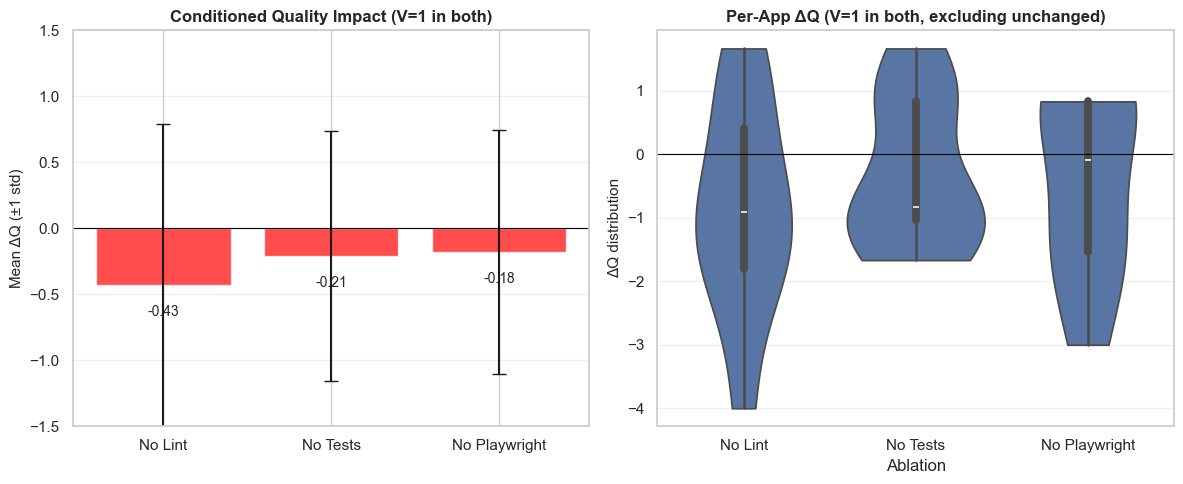


### Notable Conditioned ΔQ by Ablation

**No Lint:**
  Best improvements: Cases personal-expense-tracker_trpc-agent_claude_gemini, plant-care-tracker_trpc-agent_claude_gemini (ΔQ +1.7)
  Worst regressions: Cases tennis-enthusiast-platform_trpc-agent_claude_gemini, plumbing-business-landing-page_trpc-agent_claude_gemini (ΔQ -4.0)

**No Tests:**
  Best improvements: Cases personal-expense-tracker_trpc-agent_claude_gemini, plumbing-business-landing-page_trpc-agent_claude_gemini (ΔQ +1.7)
  Worst regressions: Cases engineering-job-board_trpc-agent_claude_gemini, indonesian-inventory-app_trpc-agent_claude_gemini (ΔQ -1.7)

**No Playwright:**
  Best improvements: Cases pc-gaming-niche-site_trpc-agent_claude_gemini, plant-care-tracker_trpc-agent_claude_gemini (ΔQ +0.8)
  Worst regressions: Cases plumbing-business-landing-page_trpc-agent_claude_gemini, tennis-enthusiast-platform_trpc-agent_claude_gemini (ΔQ -3.0)


In [25]:
# Visualization: Conditioned quality impact (V=1 in baseline and ablation)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: Mean ΔQ with error bars (conditioned)
q_changes = []
for label in ["no_lint", "no_tests", "no_playwright"]:
    q_delta = cond[label][f"delta_Q_{label}"]
    q_changes.append({
        "ablation": label.replace("_", " ").title(),
        "mean": q_delta.mean(),
        "std": q_delta.std(),
        "median": q_delta.median()
    })

q_df = pd.DataFrame(q_changes)
colors = ['green' if x > 0 else 'red' for x in q_df['mean']]
bars = ax1.bar(q_df['ablation'], q_df['mean'], yerr=q_df['std'], capsize=5, color=colors, alpha=0.7)
ax1.axhline(0, color='black', linewidth=0.8, linestyle='-')
ax1.set_ylabel('Mean ΔQ (±1 std)', fontsize=11)
ax1.set_title('Conditioned Quality Impact (V=1 in both)', fontsize=12, fontweight='bold')
ax1.set_ylim(-1.5, 1.5)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, q_df['mean']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + (0.05 if height > 0 else -0.15),
             f'{val:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# Right: Distribution of ΔQ (conditioned, excluding unchanged)
box_data = []
for label in ["no_lint", "no_tests", "no_playwright"]:
    q_delta = cond[label][f"delta_Q_{label}"]
    for val in q_delta:
        if val != 0:  # Only show apps that changed
            box_data.append({"Ablation": label.replace("_", " ").title(), "ΔQ": val})

box_df = pd.DataFrame(box_data)
sns.violinplot(data=box_df, x="Ablation", y="ΔQ", ax=ax2, cut=0, inner="box")
ax2.axhline(0, color='black', linewidth=0.8, linestyle='-')
ax2.set_ylabel('ΔQ distribution', fontsize=11)
ax2.set_title('Per-App ΔQ (V=1 in both, excluding unchanged)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Detail: Which apps changed most? (conditioned)
print("\n### Notable Conditioned ΔQ by Ablation")
for label in ["no_lint", "no_tests", "no_playwright"]:
    df = cond[label]
    q_col = f"delta_Q_{label}"
    
    # Find top improvements and regressions
    top_improve = df.nlargest(2, q_col)
    top_regress = df.nsmallest(2, q_col)
    
    print(f"\n**{label.replace('_', ' ').title()}:**")
    if top_improve[q_col].max() > 0:
        print(f"  Best improvements: Cases {', '.join(top_improve[KEY_COLUMN].astype(str))} (ΔQ {top_improve[q_col].max():+.1f})")
    if top_regress[q_col].min() < 0:
        print(f"  Worst regressions: Cases {', '.join(top_regress[KEY_COLUMN].astype(str))} (ΔQ {top_regress[q_col].min():+.1f})")

## Key Findings & Conclusions

### 1. **Validation has minimal impact on viability**
- All ablations slightly *improved* viability rates (+7-17%)
- Suggests validation layers catch non-critical issues rather than fundamental failures
- Core app.build scaffolding ensures basic functionality regardless of validation

### 2. **Quality effects are small but directional**
- **No Lint:** Minimal impact (+0.19), linting appears cosmetic for these apps
- **No Tests:** Slight regression (-0.27), unit tests catch real issues
- **No Playwright:** Modest improvement (+0.56), E2E tests may be overly strict

### 3. **High baseline quality validates the approach**
- 73% viability with mean Q=8.8 for viable apps
- Most apps cluster at high quality (Q≥8.3)
- Structured validation maintains consistency

### 4. **Support for paper's environment scaffolding claim**
The results demonstrate that app.build's value comes primarily from its structured environment and scaffolding rather than just validation checks. Disabling individual checks has limited impact because:
- The core architecture ensures apps follow viable patterns
- Multi-layer validation provides redundancy
- The scaffolding guides generation toward working solutions

**Recommendation:** The current validation suite is well-balanced. Consider relaxing Playwright tests slightly as they may reject functionally correct apps with minor UI quirks.

In [26]:
# Full per-app quality table: baseline and ablations (dense view with grouped columns)
cols = ["Case"]
base_tbl = scored["baseline"][cols + ["V", "Q"]].rename(columns={"V": "V_base", "Q": "Q_base"})
no_lint_tbl = scored["no_lint"][cols + ["V", "Q"]].rename(columns={"V": "V_no_lint", "Q": "Q_no_lint"})
no_tests_tbl = scored["no_tests"][cols + ["V", "Q"]].rename(columns={"V": "V_no_tests", "Q": "Q_no_tests"})
no_play_tbl = scored["no_playwright"][cols + ["V", "Q"]].rename(columns={"V": "V_no_playwright", "Q": "Q_no_playwright"})

ft = (
    base_tbl
    .merge(no_lint_tbl, on="Case", how="left")
    .merge(no_tests_tbl, on="Case", how="left")
    .merge(no_play_tbl, on="Case", how="left")
    .set_index("Case")
)

# Round Qs to 1 decimal
for col in ["Q_base", "Q_no_lint", "Q_no_tests", "Q_no_playwright"]:
    ft[col] = ft[col].round(1)

# Build grouped (MultiIndex) columns and add arrow markers inline for ablation Qs
import numpy as np

# Prefer colored HTML arrows when jinja2 is available; otherwise plain unicode
try:
    import jinja2  # noqa: F401
    use_html = True
except Exception:
    use_html = False

def arrow_marker(dq: float) -> str:
    if use_html:
        if dq > 0:
            return '<span style="color:#1a7f37">▲</span>'
        if dq < 0:
            return '<span style="color:#d1242f">▼</span>'
        return '<span style="color:#666">•</span>'
    # plain unicode fallback
    if dq > 0:
        return '▲'
    if dq < 0:
        return '▼'
    return '·'

q_base = ft["Q_base"]
q_no_lint = ft["Q_no_lint"].fillna(np.nan)
q_no_tests = ft["Q_no_tests"].fillna(np.nan)
q_no_play = ft["Q_no_playwright"].fillna(np.nan)

# Compose marked strings for ablation Qs
fmt = (lambda q, qb: f"{q:.1f}\u00A0{arrow_marker(q - qb)}" if pd.notna(q) and pd.notna(qb) else "")
q_no_lint_marked = q_no_lint.combine(q_base, fmt)
q_no_tests_marked = q_no_tests.combine(q_base, fmt)
q_no_play_marked = q_no_play.combine(q_base, fmt)

arrays = [
    ("Base", "V"), ("Base", "Q"),
    ("NoLint", "V"), ("NoLint", "Q"),
    ("NoTests", "V"), ("NoTests", "Q"),
    ("NoPlaywright", "V"), ("NoPlaywright", "Q"),
]
cols_mi = pd.MultiIndex.from_tuples(arrays)

data = {
    ("Base", "V"): ft["V_base"],
    ("Base", "Q"): q_base,
    ("NoLint", "V"): ft["V_no_lint"],
    ("NoLint", "Q"): q_no_lint_marked,
    ("NoTests", "V"): ft["V_no_tests"],
    ("NoTests", "Q"): q_no_tests_marked,
    ("NoPlaywright", "V"): ft["V_no_playwright"],
    ("NoPlaywright", "Q"): q_no_play_marked,
}

df_out = pd.DataFrame(data, index=ft.index)

# Build mask for rows where any V == 0 (baseline or any ablation)
mask_v0 = (
    (ft["V_base"] == 0)
    | (ft["V_no_lint"] == 0)
    | (ft["V_no_tests"] == 0)
    | (ft["V_no_playwright"] == 0)
)

if use_html:
    # Format with HTML-enabled styler and strike-through rows failing viability in baseline or ablations
    styler = (df_out
              .style
              .format({("Base", "Q"): "{:.1f}"}, na_rep="")
              .set_properties(**{"white-space": "nowrap"})
              .format(escape=False)
             )
    def strike(df: pd.DataFrame):
        arr = np.where(mask_v0.values[:, None], 'text-decoration: line-through;', '')
        return pd.DataFrame(arr, index=df.index, columns=df.columns)
    styler = styler.apply(strike, axis=None)
    display(styler)
else:
    # Plain display without HTML coloring; apply strike-through to index text using combining character
    def strike_text(s: str) -> str:
        return ''.join(ch + '\u0336' for ch in s)
    df_show = df_out.copy()
    idx = []
    for i, row in enumerate(df_out.index):
        idx.append(strike_text(row) if mask_v0.iloc[i] else row)
    df_show.index = idx
    display(df_show)



Base  \
                                                                                                          V   
basic-inventory-system_trpc-agent_claude_gemini                                                           1   
b̶e̶e̶r̶-̶c̶o̶u̶n̶t̶e̶r̶-̶a̶p̶p̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶                        0   
b̶i̶r̶t̶h̶d̶a̶y̶-̶w̶i̶s̶h̶-̶a̶p̶p̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶                      1   
book-library-manager_trpc-agent_claude_gemini                                                             1   
b̶o̶o̶k̶m̶a̶r̶k̶-̶m̶a̶n̶a̶g̶e̶m̶e̶n̶t̶-̶a̶p̶p̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶          1   
car-maintenance-dashboard_trpc-agent_claude_gemini                                                        1   
cat-conspiracy-tracker_trpc-agent_claude_gemini                                                           1   
city-trip-advisor_trpc-agent_claude_gemini                                                                1   
currency-converter_trpc-agent_claude_gemini                                                               1   
daily-pattern-visualizer_trpc-agent_claude_gemini                                                         1   
engineering-job-board_trpc-agent_claude_gemini                                                            1   
event-tracker_trpc-agent_claude_gemini                                                                    1   
g̶y̶m̶-̶c̶r̶m̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶                                          0   
habit-tracker-app_trpc-agent_claude_gemini                                                                1   
h̶o̶m̶e̶-̶l̶a̶b̶-̶i̶n̶v̶e̶n̶t̶o̶r̶y̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶                    0   
indonesian-inventory-app_trpc-agent_claude_gemini                                                         1   
k̶a̶n̶j̶i̶-̶f̶l̶a̶s̶h̶c̶a̶r̶d̶s̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶                        0   
p̶a̶n̶t̶r̶y̶-̶i̶n̶v̶e̶n̶t̶o̶r̶y̶-̶a̶p̶p̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶                0   
p̶a̶s̶t̶e̶l̶-̶b̶l̶u̶e̶-̶n̶o̶t̶e̶s̶-̶a̶p̶p̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶              1   
pc-gaming-niche-site_trpc-agent_claude_gemini                                                             1   
personal-expense-tracker_trpc-agent_claude_gemini                                                         1   
plant-care-tracker_trpc-agent_claude_gemini                                                               1   
plumbing-business-landing-page_trpc-agent_claude_gemini                                                   1   
p̶o̶m̶o̶d̶o̶r̶o̶-̶s̶t̶u̶d̶y̶-̶t̶i̶m̶e̶r̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶                0   
r̶e̶c̶i̶p̶e̶-̶s̶h̶a̶r̶i̶n̶g̶-̶p̶l̶a̶t̶f̶o̶r̶m̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶          1   
r̶o̶o̶m̶m̶a̶t̶e̶-̶c̶h̶o̶r̶e̶-̶w̶h̶e̶e̶l̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶                0   
t̶e̶a̶c̶h̶e̶r̶-̶q̶u̶e̶s̶t̶i̶o̶n̶-̶b̶a̶n̶k̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶              0   
t̶e̶n̶n̶i̶s̶-̶e̶n̶t̶h̶u̶s̶i̶a̶s̶t̶-̶p̶l̶a̶t̶f̶o̶r̶m̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶    1   
t̶o̶d̶o̶-̶l̶i̶s̶t̶-̶w̶i̶t̶h̶-̶m̶o̶o̶d̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶                  1   
wellness-score-tracker_trpc-agent_claude_gemini                                                           1   

                                                                                                              \
                                                                                                           Q   
basic-inventory-system_trpc-agent_claude_gemini                                                         10.0   
b̶e̶e̶r̶-̶c̶o̶u̶n̶t̶e̶r̶-̶a̶p̶p̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶                       0.0   
b̶i̶r̶t̶h̶d̶a̶y̶-̶w̶i̶s̶h̶-̶a̶p̶p̶_̶t̶r̶p̶c̶-̶a̶g̶e̶n̶t̶_̶c̶l̶a̶u̶d̶e̶_̶g̶e̶m̶i̶n̶i̶                  

In [27]:
# Interactive row filters for the dense table (if supported)
try:
    import ipywidgets as widgets
    from IPython.display import display, HTML
except Exception as e:
    print("ipywidgets not available. Install with `pip install ipywidgets` to enable filters.")
else:
    if 'ft' not in globals() or 'df_out' not in globals():
        print("Run the dense table cell first to build `ft` and `df_out`.")
    else:
        # Widgets
        search = widgets.Text(placeholder='Filter Case contains...', description='Search:', layout=widgets.Layout(width='300px'))
        viab = widgets.Dropdown(
            options=[('Any', 'any'), ('Base V=1', 'base1'), ('All V=1', 'all1'), ('Any V=0', 'any0')],
            value='any', description='Viability:'
        )
        changed = widgets.Checkbox(value=False, description='Only changed (Q ≠ base)')
        box = widgets.HBox([search, viab, changed])
        out = widgets.Output()

        def compute_changed_mask(frame):
            qb = frame['Q_base']
            m = (
                (frame['Q_no_lint'] - qb).abs().fillna(0) > 1e-9
            ) | (
                (frame['Q_no_tests'] - qb).abs().fillna(0) > 1e-9
            ) | (
                (frame['Q_no_playwright'] - qb).abs().fillna(0) > 1e-9
            )
            return m

        def apply_filters(*_):
            mask = pd.Series(True, index=ft.index)
            # Search
            if search.value:
                mask &= pd.Series(ft.index).str.contains(search.value, case=False, na=False).values
            # Viability
            if viab.value == 'base1':
                mask &= (ft['V_base'] == 1).values
            elif viab.value == 'all1':
                mask &= ((ft[['V_base', 'V_no_lint', 'V_no_tests', 'V_no_playwright']] == 1).all(axis=1)).values
            elif viab.value == 'any0':
                mask &= (
                    (ft['V_base'] == 0)
                    | (ft['V_no_lint'] == 0)
                    | (ft['V_no_tests'] == 0)
                    | (ft['V_no_playwright'] == 0)
                ).values
            # Changed only
            if changed.value:
                mask &= compute_changed_mask(ft).values

            with out:
                out.clear_output()
                view_idx = ft.index[mask]
                view = df_out.loc[view_idx]
                # Strike-through styling consistent with previous cell
                if 'use_html' in globals() and use_html:
                    sty = (view.style
                           .format({('Base', 'Q'): '{:.1f}'}, na_rep='')
                           .set_properties(**{'white-space': 'nowrap'})
                           .format(escape=False))
                    # Build strike mask subset
                    sub_mask_v0 = (
                        (ft.loc[view_idx, 'V_base'] == 0)
                        | (ft.loc[view_idx, 'V_no_lint'] == 0)
                        | (ft.loc[view_idx, 'V_no_tests'] == 0)
                        | (ft.loc[view_idx, 'V_no_playwright'] == 0)
                    )
                    arr = np.where(sub_mask_v0.values[:, None], 'text-decoration: line-through;', '')
                    sty = sty.apply(lambda _: pd.DataFrame(arr, index=view.index, columns=view.columns), axis=None)
                    display(sty)
                else:
                    # Fallback plain view
                    display(view)

        # Wire events
        search.observe(apply_filters, names='value')
        viab.observe(apply_filters, names='value')
        changed.observe(apply_filters, names='value')

        display(box)
        display(out)
        apply_filters()


Output()

In [28]:
# Assessor bias analysis (A1 vs A2): impact on Q and V
import numpy as np
import pandas as pd

# Build long dataframe with Assignee, Q, V, config
rows = []
for cfg in ["baseline", "no_lint", "no_tests", "no_playwright"]:
    if cfg not in raw or cfg not in scored:
        continue
    df_assignee = raw[cfg][[KEY_COLUMN, "Assignee"]].copy()
    df_qv = scored[cfg][[KEY_COLUMN, "Q", "V"]].copy()
    m = df_qv.merge(df_assignee, on=KEY_COLUMN, how="left")
    m["config"] = cfg
    rows.append(m)
assess = pd.concat(rows, ignore_index=True)
assess = assess.dropna(subset=["Assignee"]).copy()

# Helper: Welch t-test and Fisher exact if scipy available
try:
    from scipy import stats  # type: ignore
    have_scipy = True
except Exception:
    have_scipy = False

def welch_t(a: np.ndarray, b: np.ndarray):
    if have_scipy:
        t, p = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
        return float(t), float(p)
    # fallback: return NaNs
    return np.nan, np.nan

def fisher_v(a1:int, a0:int, b1:int, b0:int):
    if have_scipy:
        table = np.array([[a1, a0],[b1, b0]])
        _, p = stats.fisher_exact(table)
        return float(p)
    return np.nan

# Overall comparison (all configs combined)
res = []
for scope, df in [("overall", assess)] + [(f"config={c}", assess[assess["config"]==c]) for c in assess["config"].unique()]:
    g = df.groupby("Assignee")
    if set(g.groups.keys()) < {"A1", "A2"}:
        continue
    q_a1 = g.get_group("A1")["Q"].dropna().values
    q_a2 = g.get_group("A2")["Q"].dropna().values
    v_a1 = g.get_group("A1")["V"].dropna().values
    v_a2 = g.get_group("A2")["V"].dropna().values

    t_q, p_q = welch_t(q_a1, q_a2)
    p_v = fisher_v(int(v_a1.sum()), int((v_a1==0).sum()), int(v_a2.sum()), int((v_a2==0).sum()))

    res.append({
        "scope": scope,
        "n_A1": len(q_a1),
        "n_A2": len(q_a2),
        "Q_mean_A1": np.nanmean(q_a1),
        "Q_mean_A2": np.nanmean(q_a2),
        "ΔQ(A2-A1)": np.nanmean(q_a2) - np.nanmean(q_a1),
        "Welch_t": t_q,
        "p_Q": p_q,
        "V_rate_A1": np.nanmean(v_a1),
        "V_rate_A2": np.nanmean(v_a2),
        "ΔV(A2-A1)": np.nanmean(v_a2) - np.nanmean(v_a1),
        "p_V(fisher)": p_v,
    })

assessor_summary = pd.DataFrame(res)
# Round for display
display(assessor_summary.round({"Q_mean_A1":2, "Q_mean_A2":2, "ΔQ(A2-A1)":2, "Welch_t":2, "p_Q":4, "V_rate_A1":2, "V_rate_A2":2, "ΔV(A2-A1)":2, "p_V(fisher)":4}))

# Optional: per-AB check distribution by assessor (baseline only)
from collections import Counter
base = raw["baseline"]
per_ab = {}
for col in AB_COLUMNS:
    cnt = {ass: Counter(base[base["Assignee"]==ass][col].astype(str)) for ass in ["A1","A2"]}
    per_ab[col] = {
        "A1_PASS": int(cnt["A1"].get("PASS",0)),
        "A1_WARN": int(cnt["A1"].get("WARN",0)),
        "A1_FAIL": int(cnt["A1"].get("FAIL",0)),
        "A1_NA": int(cnt["A1"].get("NA",0)),
        "A2_PASS": int(cnt["A2"].get("PASS",0)),
        "A2_WARN": int(cnt["A2"].get("WARN",0)),
        "A2_FAIL": int(cnt["A2"].get("FAIL",0)),
        "A2_NA": int(cnt["A2"].get("NA",0)),
    }
per_ab_df = pd.DataFrame(per_ab).T
display(per_ab_df)


,scope,n_A1,n_A2,Q_mean_A1,Q_mean_A2,ΔQ(A2-A1),Welch_t,p_Q,V_rate_A1,V_rate_A2,ΔV(A2-A1),p_V(fisher)
0,overall,82,38,8.43,7.64,-0.80,1.27,0.2093,0.82,0.79,-0.03,0.8042
1,config=no_lint,20,10,7.97,8.82,0.85,-1.00,0.3255,0.75,0.90,0.15,0.6328
2,config=no_tests,17,13,9.12,6.06,-3.06,2.42,0.0295,0.94,0.62,-0.33,0.0606
3,config=no_playwright,15,15,9.02,8.22,-0.81,0.79,0.4369,0.93,0.87,-0.07,1.0000


,A1_PASS,A1_WARN,A1_FAIL,A1_NA,A2_PASS,A2_WARN,A2_FAIL,A2_NA
AB-01 Boot,25,2,3,0,0,0,0,0
AB-02 Prompt,19,3,5,0,0,0,0,0
AB-03 Create,22,2,0,0,0,0,0,0
AB-04 View/Edit,18,1,1,0,0,0,0,0
AB‑06 Clickable Sweep,20,4,1,0,0,0,0,0
AB‑07 Performance >75,24,2,0,0,0,0,0,0


In [29]:
# Conclusions on assessor bias (uses assessor_summary)
import numpy as np
import pandas as pd

if 'assessor_summary' not in globals() or assessor_summary.empty:
    print('Run the assessor bias analysis cell first to populate `assessor_summary`.')
else:
    df = assessor_summary.copy()
    # Helper: Holm-Bonferroni multiple testing correction
    def holm_bonferroni(pvals, alpha=0.05):
        p = np.array([v if pd.notna(v) else 1.0 for v in pvals], dtype=float)
        m = len(p)
        order = np.argsort(p)
        rej = np.zeros(m, dtype=bool)
        for k, idx in enumerate(order):
            thr = alpha / (m - k)
            if p[idx] <= thr:
                rej[idx] = True
            else:
                # once not rejected, larger p won't be rejected
                break
        return rej

    # Apply to V (Fisher) and Q (Welch)
    v_mask = holm_bonferroni(df['p_V(fisher)'].fillna(1.0).values, alpha=0.05)
    q_mask = holm_bonferroni(df['p_Q'].fillna(1.0).values, alpha=0.05)

    df['sig_V@0.05(Holm)'] = v_mask
    df['sig_Q@0.05(Holm)'] = q_mask

    # Print concise conclusions
    print('Assessor bias conclusions (Holm-Bonferroni, alpha=0.05):')
    any_v = bool(df['sig_V@0.05(Holm)'].any())
    any_q = bool(df['sig_Q@0.05(Holm)'].any())

    if not any_v and not any_q:
        print('- No statistically significant differences between A1 and A2 in viability rates or quality scores across tested scopes.')
    else:
        if any_v:
            print('- Significant differences in viability rates (A1 vs A2):')
            for _, r in df[df['sig_V@0.05(Holm)']].iterrows():
                print(f"  * {r['scope']}: ΔV(A2-A1)={r['ΔV(A2-A1)']:.2f}, p_V={r['p_V(fisher)']:.4f}")
        if any_q:
            print('- Significant differences in quality (A1 vs A2):')
            for _, r in df[df['sig_Q@0.05(Holm)']].iterrows():
                print(f"  * {r['scope']}: ΔQ(A2-A1)={r['ΔQ(A2-A1)']:.2f}, p_Q={r['p_Q']:.4f}")

    # Guidance
    print('\nReviewer-facing notes:')
    print('- We correct for multiple comparisons using Holm-Bonferroni. Raw p-values are in assessor_summary.')
    print('- If any scope is significant, inspect per-AB check distributions to identify where assessor judgments diverge (see per_ab_df).')
    print('- Consider stratifying by task type to control for case mix if assessor workload differs.')



Assessor bias conclusions (Holm-Bonferroni, alpha=0.05):
- No statistically significant differences between A1 and A2 in viability rates or quality scores across tested scopes.

Reviewer-facing notes:
- We correct for multiple comparisons using Holm-Bonferroni. Raw p-values are in assessor_summary.
- If any scope is significant, inspect per-AB check distributions to identify where assessor judgments diverge (see per_ab_df).
- Consider stratifying by task type to control for case mix if assessor workload differs.


In [30]:
# Open-model status.json analysis: success rates and variance (robust path resolution)
import json
from pathlib import Path
import numpy as np
import pandas as pd

candidates = [
    Path('dataset/openmodels'),
    Path.cwd() / 'dataset/openmodels',
    Path('/Users/evgenii.kniazev/projects/app.build-neurips25/dataset/openmodels'),
]
status_paths = []
for base in candidates:
    if base.exists():
        status_paths.extend([str(p) for p in base.rglob('status.json')])

if not status_paths:
    print('No open-model status.json files found under dataset/openmodels (checked absolute and relative paths)')
else:
    rows = []
    for p in status_paths:
        try:
            with open(p, 'r') as f:
                s = json.load(f)
            cfg = s.get('config', {})
            rows.append({
                'path': p,
                'success': bool(s.get('success')),
                'exit_code': s.get('exit_code'),
                'duration_s': s.get('duration_seconds'),
                'prompt': cfg.get('prompt_name'),
                'template': cfg.get('template_id'),
                'coding_model_name': cfg.get('coding_model_name'),
                'universal_model_name': cfg.get('universal_model_name'),
            })
        except Exception:
            continue
    df = pd.DataFrame(rows)
    def model_family(name: str) -> str:
        if not isinstance(name, str):
            return 'unknown'
        if name.startswith('qwen'):
            return 'Qwen3'
        if name.startswith('gpt-oss'):
            return 'GPT-OSS'
        return name
    df['model_family'] = df['coding_model_name'].apply(model_family)

    def wilson_ci(k, n, alpha=0.05):
        if n == 0:
            return (np.nan, np.nan)
        from math import sqrt
        z = 1.959963984540054
        phat = k / n
        denom = 1 + z**2/n
        center = (phat + z**2/(2*n)) / denom
        half = z * sqrt((phat*(1-phat) + z**2/(4*n))/n) / denom
        return (center - half, center + half)

    fam_stats = []
    for fam, g in df.groupby('model_family'):
        n = len(g); k = int(g['success'].sum())
        ci = wilson_ci(k, n)
        fam_stats.append({
            'model_family': fam,
            'n_runs': n,
            'success_rate': k/n if n else np.nan,
            'ci_low': ci[0],
            'ci_high': ci[1],
            'mean_duration_s': float(np.nanmean(g['duration_s'])),
            'std_duration_s': float(np.nanstd(g['duration_s'])),
        })
    fam_df = pd.DataFrame(fam_stats).sort_values('model_family')
    display(fam_df.round({'success_rate':3,'ci_low':3,'ci_high':3,'mean_duration_s':1,'std_duration_s':1}))

    pivot = (df.pivot_table(index='prompt', columns='model_family', values='success', aggfunc=['mean','count']))
    display(pivot)

    var_rows = []
    for fam, g1 in df.groupby('model_family'):
        for prm, g2 in g1.groupby('prompt'):
            if len(g2) >= 2:
                var_rows.append({
                    'model_family': fam,
                    'prompt': prm,
                    'n_runs': len(g2),
                    'success_rate': g2['success'].mean(),
                    'success_std': g2['success'].std(ddof=0),
                    'duration_mean_s': float(np.nanmean(g2['duration_s'])),
                    'duration_std_s': float(np.nanstd(g2['duration_s'])),
                })
    var_df = pd.DataFrame(var_rows).sort_values(['model_family','prompt'])
    if not var_df.empty:
        display(var_df)
        agg = var_df.groupby('model_family').agg(
            prompts_with_repeats=('prompt','nunique'),
            avg_success_std=('success_std','mean'),
            max_success_std=('success_std','max'),
            avg_duration_std_s=('duration_std_s','mean')
        ).reset_index()
        display(agg)
    else:
        print('No prompts with multiple runs per model family found; per-prompt variance unavailable.')


,model_family,n_runs,success_rate,ci_low,ci_high,mean_duration_s,std_duration_s
0,GPT-OSS,270,0.933,0.897,0.957,496.4,294.5
1,Qwen3,270,0.889,0.846,0.921,760.7,323.4


mean             count      
model_family                     GPT-OSS     Qwen3 GPT-OSS Qwen3
prompt                                                          
basic-inventory-system          1.000000  1.000000       9     9
beer-counter-app                0.666667  0.666667       9     9
birthday-wish-app               0.666667  0.333333       9     9
book-library-manager            0.666667  1.000000       9     9
bookmark-management-app         1.000000  1.000000       9     9
car-maintenance-dashboard       1.000000  1.000000       9     9
cat-conspiracy-tracker          1.000000  1.000000       9     9
city-trip-advisor               0.666667  1.000000       9     9
currency-converter              1.000000  1.000000       9     9
daily-pattern-visualizer        1.000000  1.000000       9     9
engineering-job-board           0.666667  0.666667       9     9
event-tracker                   1.000000  1.000000       9     9
gym-crm                         1.000000  1.000000       9     9
habit-tracker-app               1.000000  1.000000       9     9
home-lab-inventory              1.000000  1.000000       9     9
indonesian-inventory-app        0.666667  0.666667       9     9
kanji-flashcards                1.000000  0.666667       9     9
pantry-inventory-app            1.000000  1.000000       9     9
pastel-blue-notes-app           1.000000  1.000000       9     9
pc-gaming-niche-site            1.000000  1.000000       9     9
personal-expense-tracker        1.000000  1.000000       9     9
plant-care-tracker              1.000000  1.000000       9     9
plumbing-business-landing-page  1.000000  0.333333       9     9
pomodoro-study-timer            1.000000  0.333333       9     9
recipe-sharing-platform         1.000000  1.000000       9     9
roommate-chore-wheel            1.000000  1.000000       9     9
teacher-question-bank           1.000000  1.000000       9     9
tennis-enthusiast-platform      1.000000  1.000000       9     9
todo-list-with-mood             1.000000  1.000000       9     9
wellness-score-tracker          1.000000  1.000000       9     9

,model_family,prompt,n_runs,success_rate,success_std,duration_mean_s,duration_std_s
0,GPT-OSS,basic-inventory-system,9,1.000000,0.000000,391.349906,125.750955
1,GPT-OSS,beer-counter-app,9,0.666667,0.471405,928.540545,593.238795
2,GPT-OSS,birthday-wish-app,9,0.666667,0.471405,1045.701026,448.993839
3,GPT-OSS,book-library-manager,9,0.666667,0.471405,447.900115,24.090853
4,GPT-OSS,bookmark-management-app,9,1.000000,0.000000,484.566582,32.184175
5,GPT-OSS,car-maintenance-dashboard,9,1.000000,0.000000,303.159452,133.317640
6,GPT-OSS,cat-conspiracy-tracker,9,1.000000,0.000000,361.673473,13.041352
7,GPT-OSS,city-trip-advisor,9,0.666667,0.471405,180.383575,125.417368
8,GPT-OSS,currency-converter,9,1.000000,0.000000,513.136546,145.845739
9,GPT-OSS,daily-pattern-visualizer,9,1.000000,0.000000,377.678586,17.060675


,model_family,prompts_with_repeats,avg_success_std,max_success_std,avg_duration_std_s
0,GPT-OSS,30,0.094281,0.471405,158.879343
1,Qwen3,30,0.109994,0.471405,217.628547


In [31]:
# Open-model telemetry.json analysis: token/call/time statistics and correlation with success
import json
from pathlib import Path
import numpy as np
import pandas as pd

# Collect status (for success and model family) and telemetry (for usage)
base_candidates = [
    Path('dataset/openmodels'),
    Path.cwd() / 'dataset/openmodels',
    Path('/Users/evgenii.kniazev/projects/app.build-neurips25/dataset/openmodels'),
]
run_dirs = []
for base in base_candidates:
    if base.exists():
        for status_path in base.rglob('status.json'):
            run_dirs.append(status_path.parent)

if not run_dirs:
    print('No open-model run directories found.')
else:
    rows_status = []
    rows_tel = []
    for rd in run_dirs:
        status_path = rd / 'status.json'
        tel_path = rd / 'telemetry.json'
        # status
        status = {}
        try:
            with open(status_path, 'r') as f:
                s = json.load(f)
            cfg = s.get('config', {})
            status = {
                'run_dir': str(rd),
                'prompt': cfg.get('prompt_name'),
                'coding_model_name': cfg.get('coding_model_name'),
                'universal_model_name': cfg.get('universal_model_name'),
                'success': bool(s.get('success')),
                'exit_code': s.get('exit_code'),
                'duration_s_status': s.get('duration_seconds'),
            }
        except Exception:
            continue
        rows_status.append(status)
        # telemetry
        try:
            with open(tel_path, 'r') as f:
                t = json.load(f)
            # per-model breakdown
            for model_key, stats in t.items():
                rows_tel.append({
                    'run_dir': str(rd),
                    'model_key': model_key,
                    'total_calls': stats.get('total_calls'),
                    'total_input_tokens': stats.get('total_input_tokens'),
                    'total_output_tokens': stats.get('total_output_tokens'),
                    'total_time_seconds': stats.get('total_time_seconds'),
                    'total_cache_creation_tokens': stats.get('total_cache_creation_tokens'),
                    'total_cache_read_tokens': stats.get('total_cache_read_tokens'),
                })
        except Exception:
            # telemetry may be missing
            pass

    df_status = pd.DataFrame(rows_status)
    df_tel = pd.DataFrame(rows_tel)

    def model_family(name: str) -> str:
        if not isinstance(name, str):
            return 'unknown'
        if name.startswith('qwen'):
            return 'Qwen3'
        if name.startswith('gpt-oss'):
            return 'GPT-OSS'
        return name

    df_status['model_family'] = df_status['coding_model_name'].apply(model_family)

    # Merge per-run total usage by summing telemetry across model keys
    if not df_tel.empty:
        per_run_usage = (df_tel.groupby('run_dir')[
            ['total_calls','total_input_tokens','total_output_tokens','total_time_seconds',
             'total_cache_creation_tokens','total_cache_read_tokens']
        ].sum(min_count=1).reset_index())
    else:
        per_run_usage = pd.DataFrame(columns=['run_dir'])

    runs = df_status.merge(per_run_usage, on='run_dir', how='left')

    # Summary per model family
    fam_usage = runs.groupby('model_family').agg(
        n_runs=('run_dir','nunique'),
        success_rate=('success','mean'),
        mean_input_tokens=('total_input_tokens','mean'),
        mean_output_tokens=('total_output_tokens','mean'),
        mean_calls=('total_calls','mean'),
        mean_time_s=('total_time_seconds','mean'),
        std_time_s=('total_time_seconds','std'),
    ).reset_index()
    display(fam_usage.round({'success_rate':3,'mean_input_tokens':0,'mean_output_tokens':0,'mean_calls':1,'mean_time_s':1,'std_time_s':1}))

    # Per-model_key telemetry to see which providers dominate usage
    if not df_tel.empty:
        key_usage = df_tel.groupby('model_key').agg(
            runs=('run_dir','nunique'),
            total_calls=('total_calls','sum'),
            input_tokens=('total_input_tokens','sum'),
            output_tokens=('total_output_tokens','sum'),
            total_time_s=('total_time_seconds','sum')
        ).sort_values('input_tokens', ascending=False).reset_index()
        display(key_usage)

    # Correlate usage with success
    if not runs.empty:
        print('\nCorrelation of usage with success (point-biserial approximations):')
        for col in ['total_input_tokens','total_output_tokens','total_calls','total_time_seconds']:
            if col in runs.columns:
                x = runs[col].astype(float)
                y = runs['success'].astype(int)
                if x.notna().sum() > 2:
                    r = np.corrcoef(np.nan_to_num(x, nan=np.nanmean(x)), y)[0,1]
                    print(f'- {col}: r≈{r:.2f} (n={len(runs)})')

    # Per-prompt success and mean tokens per family
    if not runs.empty:
        pivot_succ = runs.pivot_table(index='prompt', columns='model_family', values='success', aggfunc=['mean','count'])
        display(pivot_succ)
        pivot_tokens = runs.pivot_table(index='prompt', columns='model_family', values='total_input_tokens', aggfunc='mean')
        display(pivot_tokens.round(0))


,model_family,n_runs,success_rate,mean_input_tokens,mean_output_tokens,mean_calls,mean_time_s,std_time_s
0,GPT-OSS,270,0.933,1183335.0,49126.0,152.2,395.5,258.4
1,Qwen3,270,0.889,1251291.0,37226.0,137.5,739.3,420.3


,model_key,runs,total_calls,input_tokens,output_tokens,total_time_s
0,qwen/qwen3-coder,270,35253,335559237,9896346,196670.062696
1,openai/gpt-oss-120b,267,39306,317334222,13120815,103778.249986
2,gemini-2.5-flash-preview-05-20,540,2223,3823377,234303,4463.964134
3,gemini-2.5-flash-lite-preview-06-17,537,1446,632265,63588,1477.910959



Correlation of usage with success (point-biserial approximations):
- total_input_tokens: r≈0.03 (n=540)
- total_output_tokens: r≈-0.01 (n=540)
- total_calls: r≈0.01 (n=540)
- total_time_seconds: r≈-0.12 (n=540)


mean             count      
model_family                     GPT-OSS     Qwen3 GPT-OSS Qwen3
prompt                                                          
basic-inventory-system          1.000000  1.000000       9     9
beer-counter-app                0.666667  0.666667       9     9
birthday-wish-app               0.666667  0.333333       9     9
book-library-manager            0.666667  1.000000       9     9
bookmark-management-app         1.000000  1.000000       9     9
car-maintenance-dashboard       1.000000  1.000000       9     9
cat-conspiracy-tracker          1.000000  1.000000       9     9
city-trip-advisor               0.666667  1.000000       9     9
currency-converter              1.000000  1.000000       9     9
daily-pattern-visualizer        1.000000  1.000000       9     9
engineering-job-board           0.666667  0.666667       9     9
event-tracker                   1.000000  1.000000       9     9
gym-crm                         1.000000  1.000000       9     9
habit-tracker-app               1.000000  1.000000       9     9
home-lab-inventory              1.000000  1.000000       9     9
indonesian-inventory-app        0.666667  0.666667       9     9
kanji-flashcards                1.000000  0.666667       9     9
pantry-inventory-app            1.000000  1.000000       9     9
pastel-blue-notes-app           1.000000  1.000000       9     9
pc-gaming-niche-site            1.000000  1.000000       9     9
personal-expense-tracker        1.000000  1.000000       9     9
plant-care-tracker              1.000000  1.000000       9     9
plumbing-business-landing-page  1.000000  0.333333       9     9
pomodoro-study-timer            1.000000  0.333333       9     9
recipe-sharing-platform         1.000000  1.000000       9     9
roommate-chore-wheel            1.000000  1.000000       9     9
teacher-question-bank           1.000000  1.000000       9     9
tennis-enthusiast-platform      1.000000  1.000000       9     9
todo-list-with-mood             1.000000  1.000000       9     9
wellness-score-tracker          1.000000  1.000000       9     9

model_family,GPT-OSS,Qwen3
prompt,,
basic-inventory-system,910496.0,1047351.0
beer-counter-app,1037558.0,612006.0
birthday-wish-app,1523549.0,1562789.0
book-library-manager,1415667.0,1027625.0
bookmark-management-app,2735183.0,1598513.0
car-maintenance-dashboard,956248.0,2519285.0
cat-conspiracy-tracker,1141254.0,1005384.0
city-trip-advisor,173207.0,604998.0
currency-converter,791087.0,605373.0
